In [2]:
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.stats

In [3]:
# define functions used for plotting 
def hw_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

In [4]:
# automatically download data 
# stationIDs = {'Baltimore': 'USW00093784',}
# import ulmo
# st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)
#st[st.name.str.contains('BIRMINGHAM')]

In [12]:
ls GHCN*.csv

GHCNpairedstations.csv
GHCNpairedstations_checked.csv
GHCNpairedstations_checkedrecordlengths.csv
GHCNwithBrightness.csv


In [13]:
pairs = pd.read_csv('GHCNpairedstations.csv')
pairs = pd.read_csv('USghcnpairs_stationlengths.csv')

In [6]:
df = pairs[pairs['Urban station'].str.contains('US')]

In [21]:
df.loc[195]

Unnamed: 0                  195
City                    El Paso
Urban station       USW00023044
Urban Lat                31.811
Urban Lon              -106.375
Urban brightness             63
Rural station       USC00290125
Rural Lat                32.116
Rural Lon              -106.866
Rural brightness              6
Name: 195, dtype: object

El Paso
No min heatwaves detected for El Paso
No Max heatwaves detected for El Paso


ZeroDivisionError: integer division or modulo by zero

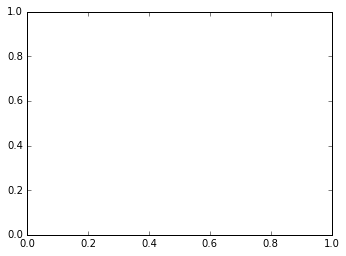

In [24]:
dict = ['Min', 'Max']
city_list = [195,200, 203, 204]# El Paso, Baltimore Las Vegas, Portland, 
for i in city_list: #range(0, 1):#df.shape[0]): 
    city = df.loc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = df.loc[i]['Urban station']
    ruralID = df.loc[i]['Rural station']

    #     city = df.iloc[i]['City']
#     city = unicode(city, errors = 'ignore')
#     urbanID = df.iloc[i]['Urban station']
#     ruralID = df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()): 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1965
        tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.)
        tmax = pd.to_numeric(ruraldata['TMAX']['1985-01-01':].value/10.) 

#        filename = './data/mindailytempthresholds'+city+ '.npy'
#         if os.path.isfile(filename): 
#             minthresh = np.load(filename)
#         else: 
#             summary = tmin.dropna().groupby(tmin.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
#             ninetieth = summary.values[5::10]
#             ninetyfifth = summary.values[6::10]
#             ninetyeigth = summary.values[7::10]
#             ninetyninth = summary.values[8::10]
#             minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
#             np.save(('./data/mindailytempthresholds'+city), minthresh)

#         # Calculate maximum  daily thresholds
#         tmax = pd.to_numeric(ruraldata['TMAX']['1965-01-01':].value/10.) 
#         filename = './data/maxdailytempthresholds'+city+ '.npy'
#         if os.path.isfile(filename): 
#             maxthresh = np.load(filename)
#         else: 
#             summary = tmax.dropna().groupby(tmax.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
#             ninetieth = summary.values[5::10]
#             ninetyfifth = summary.values[6::10]
#             ninetyeigth = summary.values[7::10]
#             ninetyninth = summary.values[8::10]
#             maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
#             np.save(('./data/maxdailytempthresholds'+city), maxthresh)

        numhw = 30 # number of heatwaves

        # min hw
        tmin = tmin[startdate:]
        hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
        minheatwaves = hottestmin
        
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        minheatwaves = minheatwaves.sort_values().iloc[0:10]

#         ind = np.where(hottestmin.values- minthresh[1,hottestmin.index.dayofyear] >0)
#         minheatwaves = hottestmin.iloc[ind]
#         # check that these are heatwaves
#         ind2 = np.where(minheatwaves- minthresh[1,hottestmin.index.dayofyear+1] >0)[0]
#         minheatwaves = minheatwaves[ind2]
        # check that these last 48 hours 

        # check that these aren't all the same event : must be at least 3 days apart? 

        # max hw
        tmax = tmax[startdate:]
        hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]]# Get the hottest days based off tmax
        maxheatwaves = hottestmax
#         ind = np.where(hottestmax.values- maxthresh[1,hottestmax.index.dayofyear] >0)
#         maxheatwaves = hottestmax.iloc[ind]
#         # check that these last 48 hours
#         ind2 = np.where(maxheatwaves- maxthresh[1,hottestmax.index.dayofyear+1] >0)[0]
#         maxheatwaves = maxheatwaves[ind2]
        # check that these aren't all the same event
    
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (maxheatwaves.sort_index().index.to_timestamp().values[1:] - maxheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        maxheatwaves = maxheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        maxheatwaves = maxheatwaves.sort_values().iloc[0:10]
        
        if minheatwaves.shape[0]==0: 
            print 'No min heatwaves detected for %s' %city
        if maxheatwaves.shape[0]==0: 
            print 'No Max heatwaves detected for %s' %city
        if 'AWND' in urbandata.keys():
            wind = pd.to_numeric(urbandata['AWND'][startdate:].value) 
        elif 'AWND' in ruraldata.keys():
            wind = pd.to_numeric(ruraldata['AWND'][startdate:].value)
        else: 
            wind = np.zeros(temp.shape)
            wind[:] = np.nan
            print 'No wind data'

        #calculate UHI
        UHImin = pd.to_numeric(urbandata['TMIN'].value/10.) - tmin
        UHImax = pd.to_numeric(urbandata['TMAX'].value/10.) - tmax
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([minheatwaves.shape[0], 11])
        compositeUHI = np.zeros([minheatwaves.shape[0], 11])
        composite_wind = np.zeros([minheatwaves.shape[0], 11])    

        j = 0
        for UHI, temp, heatwaves in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves]): 
                minmax = dict[j]
                i = 0
                try: 
                    for dates in heatwaves.index[:]: 
                        compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        composite_wind[i,:] = wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                        i = i+1

                    plt.figure(figsize=[12,4])
                    plt.subplot(1,2,1)
                    tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
                    plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
                    #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
                    try: 
                        plt.title('%s %s Temp'%(minmax, city))
                    except UnicodeDecodeError : 
                        plt.title('%s Temp'%(minmax))

                    plt.ylabel('Temp. ($^\circ C$)')
                    plt.xlabel('Heatwave Day')

                    plt.subplot(1,2,2)    
                    uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
                    plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
                    try: 
                        plt.title('%s %s UHI'%(minmax, city))
                    except UnicodeDecodeError : 
                        plt.title('%s UHI'%(minmax))
                    plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
                    plt.xlabel('Heatwave Day')
                    plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
                    
                    #plt.savefig('plots/hwUHI%s%s.png'%(minmax, city.replace(" ", "")[0:5]))
                except ValueError: 
                    print 'Error plotting ', city
                j = j+1  
        #plt.clf()       
    else: 
        print 'Skipping %s'%city

In [444]:
dict = ['Min', 'Max']
slopes = np.zeros(df.shape[0])

for i in range(2, df.shape[0]): 
    city = df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = df.iloc[i]['Urban station']
    ruralID = df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN'].index, ruraldata['TMIN'].index).shape[0] > 50): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1965
        tmin = pd.to_numeric(ruraldata['TMIN']['1965-01-01':].value/10.) 
        filename = './data/mindailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            minthresh = np.load(filename)
        else: 
            summary = tmin.dropna().groupby(tmin.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/mindailytempthresholds'+city), minthresh)

        # Calculate maximum  daily thresholds
        tmax = pd.to_numeric(ruraldata['TMAX']['1965-01-01':].value/10.) 
        filename = './data/maxdailytempthresholds'+city+ '.npy'
        if os.path.isfile(filename): 
            maxthresh = np.load(filename)
        else: 
            summary = tmax.dropna().groupby(tmax.dropna().index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
            ninetieth = summary.values[5::10]
            ninetyfifth = summary.values[6::10]
            ninetyeigth = summary.values[7::10]
            ninetyninth = summary.values[8::10]
            maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
            np.save(('./data/maxdailytempthresholds'+city), maxthresh)

        numhw = 30 # number of heatwaves

        # min hw
        tmin = tmin[startdate:]
        hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
        minheatwaves = hottestmin
        
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        minheatwaves = minheatwaves.sort_values().iloc[0:10]

        # max hw
        tmax = tmax[startdate:]
        hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]]# Get the hottest days based off tmax
        maxheatwaves = hottestmax

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (maxheatwaves.sort_index().index.to_timestamp().values[1:] - maxheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        maxheatwaves = maxheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want numhw (10) of the most severe events. Save the hottest 10 events
        maxheatwaves = maxheatwaves.sort_values().iloc[0:10]
        
        if minheatwaves.shape[0]==0: 
            print 'No min heatwaves detected for %s' %city
        if maxheatwaves.shape[0]==0: 
            print 'No Max heatwaves detected for %s' %city
        
        # Import wind data 
        if 'AWND' in urbandata.keys():
            wind = pd.to_numeric(urbandata['AWND'][startdate:].value) 
        elif 'AWND' in ruraldata.keys():
            wind = pd.to_numeric(ruraldata['AWND'][startdate:].value)
        else: 
            wind = pd.DataFrame(index=tmin.index, columns=['Wind'])
            wind = wind.fillna('NaN') # with 0s rather than NaNs
            #wind = np.zeros(temp.shape)
            #wind[:] = np.nan
            print 'No wind data'
    
        if wind.shape[0]==0 : 
            wind = pd.DataFrame(index=tmin.index, columns=['Wind'])
            wind = wind.fillna('NaN') # with 0s rather than NaNs
            #wind = np.zeros(temp.shape)
            #wind[:] = np.nan
            print 'No wind data'
            
        #calculate UHI
        UHImin = pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([minheatwaves.shape[0], 11])
        compositeUHI = np.zeros([minheatwaves.shape[0], 11])
        composite_wind = np.zeros([minheatwaves.shape[0], 11])  

     
        j = 0 
        for UHI, temp, heatwaves, HWthresh in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves], [minthresh[1], maxthresh[1]]):
            #calculate hw index
            hw_day_index = np.where(temp - HWthresh[temp.index.day_of_year-1] >=0)

            minmax = dict[j]
            i = 0

            for dates in heatwaves.index[:]: 
                compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                try: 
                    composite_wind[i,:] = np.squeeze(wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values)
                except ValueError: 
                    composite_wind[i,:] = np.nan
                #composite_wind[i,:] = np.squeeze(wind[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values)
                i = i+1

            plt.figure(figsize=[20,4])
            # plot temperature 
            plt.subplot(1,5,1)
            tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
            #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
            plt.title('%s %s Temp'%(city, minmax))
            plt.ylabel('Temp. ($^\circ C$)')
            plt.xlabel('Heatwave Day')

            # plot UHI
            plt.subplot(1,5,2)    
            uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
            plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
            plt.title('%s %s UHI'%(city, minmax))
            plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
            plt.xlabel('Heatwave Day')
            plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

            # scatter temp versus UHI
            # calculate the heatwave days
            plt.subplot(1,5,4)         
            x = temp.iloc[hw_day_index].values
            y = UHI[temp.iloc[hw_day_index].index].values 
            hw_scatter(x, y, '%s Temp vs UHI HW days'%(minmax), 'Temp', 'UHI')

            plt.subplot(1,5,5)
            x = temp.drop(temp.index[hw_day_index], inplace=False)
            y = UHI[x.index].values
            x = x.values
            hw_scatter(x, y, '%s Temp vs UHI non-HW days'%(minmax), 'Temp', 'UHI')
            if j == 0 : 
                plt.savefig('plots/hwUHI%s%s.png'%(city.replace(" ", "")[0:5], minmax))

            j = j+1

        plt.subplot(1,5,3)
        uhiHandle = plt.plot(np.arange(-5,6,1),composite_wind.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(composite_wind, axis=0), linewidth = 3,color = 'black')
        plt.title('%s Avg. Wind'%(city))
        plt.ylabel('Wind')
        plt.xlabel('Heatwave Day')
        
        plt.savefig('plots/hwUHI%s%s.png'%(city.replace(" ", "")[0:5], minmax))
        plt.close("all")

Irvine
Long Beach
Columbus
Ft. Worth
No wind data
Indianapolis
Baltimore
No wind data
San Jose
No wind data
Sacramento
No wind data
Las Vegas
Portland
San Antonio
Cleveland
Pittsburgh
Minneapolis
No wind data
Seattle
Phoenix
No wind data
San Diego
St. Louis
Dallas
Boston
Tampa
Philadelphia
No wind data


IndexError: index 212 is out of bounds for axis 1 with size 58

make sure that events are unique: sort will work differently for max and min heatwaves. Make sure this is functioning properly. figure out why in Ciudad Jaurez there are events being picked up that are below 0 

Aim for 4 panel: temp, UHI, HW temp versus UHI, non-HW temp versus UHI
wind below 

Make a hw_scatter function and a hw_composite_plot function to reduce space in code?

In [ ]:
# cut off UHI at some year 
# Other things to plot
# max hw versus min hw
# mean windspeed during the event : AWND
# relative humidity during the event : 
# scatter plot UHI versus temp during the event, UHI versus temp for all time 

In [454]:
# scatter summertime temp versus UHI 

In [457]:
pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] < 20) & (pairs['Urban station'].str.contains('US'))]['City']

89       Long Beach
95       Sacramento
104       San Diego
106          Dallas
107          Boston
109    Philadelphia
116         Chicago
Name: City, dtype: object

In [23]:
# Calculate the relationship between summertime  UHI and t_min, save it out for every city
pairs = pd.read_csv('GHCNpairedstations.csv')
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

slopes           = np.zeros(paired_df.shape[0])
residuals        = np.zeros(paired_df.shape[0])
correlations     = np.zeros(paired_df.shape[0])
urban_start_date = np.zeros(paired_df.shape[0])
urban_end_date   = np.zeros(paired_df.shape[0])
rural_start_date = np.zeros(paired_df.shape[0])
rural_end_date   = np.zeros(paired_df.shape[0])
n_events = np.zeros(paired_df.shape[0])
mean_rural_temp  = np.zeros(paired_df.shape[0])
mean_UHI         = np.zeros(paired_df.shape[0])

for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1985
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        #temp = tmin
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year

        #calculate UHI
        UHI = urban_tmin - rural_tmin#pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        #UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)] 
        
        mean_UHI[i] = UHI.mean()
        mean_rural_temp[i] = urban_summer.mean()
        
        x = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        x = x[x>4]
        #y = UHI[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        y = urban_summer[(urban_summer>4) & (urban_summer < 35)]-x #y[(y< 15)]
        
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        #plt.figure()
        #handle = hw_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp', 'UHI')
        #plt.savefig('plots/hwUHI%s%s.png'%(city.replace(" ", "")[0:5], 'min'))
        #plt.close()
        try: 
            V = np.polyfit(x[ind],y[ind],1, full = True)
        
            slopes[i] = V[0][0]
            residuals[i] = V[1][0]
            correlations[i] = np.corrcoef(x[ind],y[ind])[0,1]
            n_events[i] = ind.values.sum()

        except TypeError : 
            slopes[i] = np.nan
            residuals[i] = np.nan
            correlations[i] = np.nan
    else : 
        slopes[i] = np.nan
        residuals[i] = np.nan
        correlations[i] = np.nan
        
        
    if np.mod(i,10) == 0 : 
        
        results_df = pd.DataFrame()
        results_df['City']  = paired_df['City']
        results_df['Slope'] = slopes
        results_df['Residual'] = residuals
        results_df['Correlation'] = correlations
        results_df['Urban start date'] = urban_start_date
        results_df['Urban end date'] = urban_end_date
        results_df['Rural start date'] = rural_start_date
        results_df['Rural end date'] = rural_end_date
        results_df['Data points'] = n_events
        results_df['Mean UHI'] = mean_UHI
        results_df['Mean JJA Rural Temp'] = mean_rural_temp

        results_df.to_csv('US_results_cleaned_data.csv')
        
results_df = pd.DataFrame()
results_df['City']  = paired_df['City']
results_df['Slope'] = slopes
results_df['Residual'] = residuals
results_df['Correlation'] = correlations
results_df['Urban start date'] = urban_start_date
results_df['Urban end date'] = urban_end_date
results_df['Rural start date'] = rural_start_date
results_df['Rural end date'] = rural_end_date
results_df['Data points'] = n_events
results_df['Mean UHI'] = mean_UHI
results_df['Mean JJA Rural Temp'] = mean_rural_temp

results_df.to_csv('US_results_cleaned_data.csv')

Ciudad Jurez
Mexicali
Tijuana
Mesa
Irvine
New Haven
Hartford
Providence
Birmingham
St. Petersburg
Virginia Beach
Oakland
West Palm Beach
Louisville
Charlotte
Columbus
San Bernardino
Bridgeport
St. Paul
Tucson
Fresno
Albuquerque
Kansas City
Tulsa
Ft. Worth
Austin
El Paso
Orlando
Jacksonville
Indianapolis
Richmond
Baltimore
San Jose
Las Vegas
Portland
Salt Lake City
Omaha
Oklahoma City
San Antonio
Raleigh
Cleveland
Cincinnati
Nashville
Memphis
Norfolk
Milwaukee
Buffalo
Minneapolis
Honolulu
Seattle
Phoenix
St. Louis
New Orleans
Tampa
San Francisco


KeyboardInterrupt: 

In [24]:
i

54

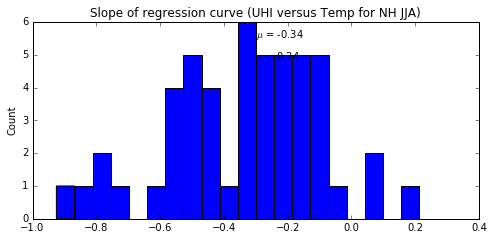

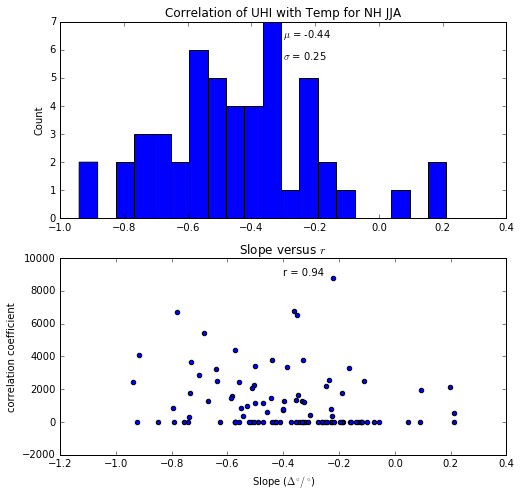

In [11]:
data = slopes
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,1)
plt.hist(data, 20)
plt.title('Slope of regression curve (UHI versus Temp for NH JJA)')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

data = correlations
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,2)
plt.hist(data, 20)
plt.title('Correlation of UHI with Temp for NH JJA')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

plt.subplot(3,1,3)
plt.title('Slope versus $r$')
plt.scatter(slopes, correlations)
plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
#plt.xlim([-1.0,0.2])
plt.ylabel('correlation coefficient')
ind = ~np.isnan(slopes) & ~np.isnan(correlations)
r = np.corrcoef(slopes[ind],correlations[ind])[0,1]
plt.annotate('r = %2.2f'%r, xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

plt.scatter(correlations, residuals)

In [15]:
results_df[results_df['Slope']< -.8]

,City,Slope,Residual,Correlation,Urban start date,Urban end date,Rural start date,Rural end date,Data points
180,Oakland,-0.925351,2410.417137,-0.939980,1985.0,2016.0,1994.0,2016.0,933.0
233,Miami,-0.849639,286.064141,-0.737669,1985.0,2016.0,2002.0,2006.0,111.0


In [743]:
results_df

,City,Slope,Residual,Correlation,Urban start date,Urban end date,Rural start date,Rural end date
5,Yerevan,-0.183046,2165.020343,-0.356213,1985.0,2005.0,1985.0,1998.0
12,Baku,-0.200179,25.702297,-0.492787,1985.0,1991.0,1985.0,1991.0
13,Antwerpen,-0.251435,2957.249217,-0.426341,1985.0,2016.0,1996.0,2016.0
15,Sarajevo,-0.371549,4119.097796,-0.639050,1985.0,2016.0,1985.0,2016.0
21,Hamilton,-0.210208,1715.817049,-0.430013,1985.0,1994.0,1985.0,2000.0
22,Winnipeg,NaN,NaN,NaN,0.0,0.0,0.0,0.0
23,Calgary,NaN,NaN,NaN,0.0,0.0,0.0,0.0
24,Ottawa,-0.022305,3099.282140,-0.043108,1985.0,2016.0,1999.0,2016.0
25,Québec,-0.151670,302.867612,-0.323177,1991.0,1994.0,1985.0,2016.0
26,Edmonton,-0.259896,1687.766677,-0.475563,2005.0,2015.0,1985.0,2015.0


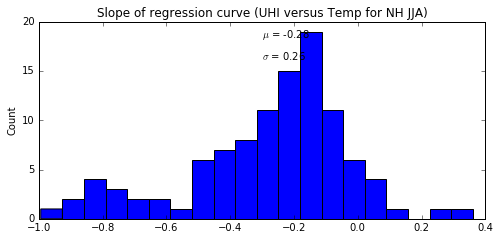

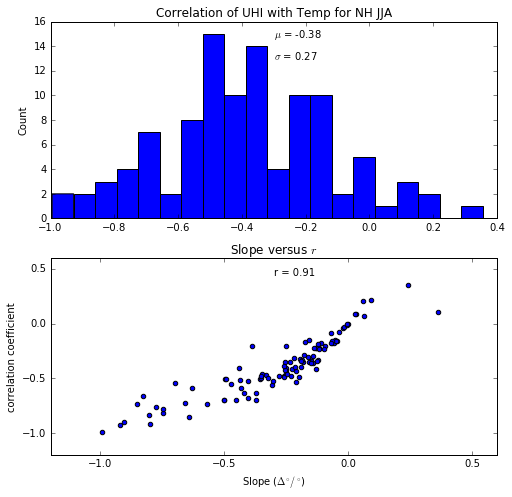

In [787]:
data = slopes
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,1)
plt.hist(data, 20)
plt.title('Slope of regression curve (UHI versus Temp for NH JJA)')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

data = correlations
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,2)
plt.hist(data, 20)
plt.title('Correlation of UHI with Temp for NH JJA')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

plt.subplot(3,1,3)
plt.title('Slope versus $r$')
plt.scatter(slopes, correlations)
plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
#plt.xlim([-1.0,0.2])
plt.ylabel('correlation coefficient')
ind = ~np.isnan(slopes) & ~np.isnan(correlations)
r = np.corrcoef(slopes[ind],correlations[ind])[0,1]
plt.annotate('r = %2.2f'%r, xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

plt.scatter(correlations, residuals)

In [740]:
print 'Mean: ', np.nanmean(slopes), 'Std: ', np.nanstd(slopes), 'Max: ', np.nanmax(slopes), 'Min: ', np.nanmin(slopes)

Mean:  -0.276294616081 Std:  0.25543711713 Max:  0.360332398879 Min:  -0.994298616962


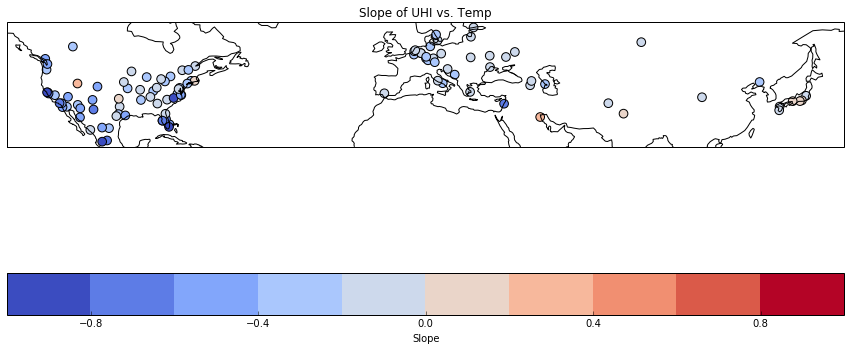

In [745]:
import matplotlib
import cartopy.crs as ccrs
fig = plt.figure(figsize=[15,15])
# Define colors 
cmap = matplotlib.cm.coolwarm
c = slopes
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 75

# Define the cartopy basemaps
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ind = np.isnan(c)
plotHandle = ax.scatter(paired_df['Urban Lon'], paired_df['Urban Lat'],#x,y,
                        c = c, s = marker_size, transform=ccrs.Geodetic(), 
                 cmap = cmap,
                 norm = norm)
     
cbar1 = plt.colorbar(plotHandle, label = 'Slope', orientation='horizontal')
plt.title('Slope of UHI vs. Temp')

fig = plt.figure(figsize=[15,15])
# Define colors 
cmap = matplotlib.cm.coolwarm
c = correlations
bounds = np.linspace(-1,1,11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
marker_size = 75

# Define the cartopy basemaps
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ind = np.isnan(c)
plotHandle = ax.scatter(paired_df['Urban Lon'], paired_df['Urban Lat'],#x,y,
                        c = c, s = marker_size, transform=ccrs.Geodetic(), 
                 cmap = cmap,
                 norm = norm)
     
cbar1 = plt.colorbar(plotHandle, label = 'Correlation', orientation='horizontal')
plt.title('Correlation of Temperature and UHI')

In [754]:
paired_df[outlier_ind]['City']

72         Chandigarh
92           Shizuoka
93          Hamamatsu
97               Kobe
109            Kuwait
205    Salt Lake City
207     Oklahoma City
Name: City, dtype: object

In [751]:
outlier_ind = correlations >0
paired_df[outlier_ind]

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Rural station,Rural Lat,Rural Lon,Rural brightness
72,72,Chandigarh,IN006012800,30.383,76.767,62.0,IN018103100,30.333,76.467,22.0
92,92,Shizuoka,JA000047656,34.983,138.400,63.0,JA000047655,34.600,138.217,18.0
93,93,Hamamatsu,JA000047654,34.717,137.717,63.0,JA000047655,34.600,138.217,18.0
97,97,Kobe,JA000047770,34.700,135.217,63.0,JA000047776,34.333,134.900,39.0
109,109,Kuwait,KU000405820,29.222,47.966,63.0,KUM00040572,29.417,48.000,41.0
205,205,Salt Lake City,USR0000ENSI,40.800,-111.916,63.0,USS0011J64S,40.840,-111.710,8.0
207,207,Oklahoma City,USW00003954,35.534,-97.646,63.0,USC00345870,35.272,-97.955,5.0


In [752]:
results_df[outlier_ind]

,City,Slope,Residual,Correlation,Urban start date,Urban end date,Rural start date,Rural end date
72,Chandigarh,0.062528,39.305509,0.072012,1985.0,2016.0,1985.0,2016.0
92,Shizuoka,0.031955,950.131455,0.086154,1985.0,2016.0,1985.0,2016.0
93,Hamamatsu,0.058848,584.481191,0.201619,1985.0,2016.0,1985.0,2016.0
97,Kobe,0.028535,785.080439,0.088615,1985.0,2016.0,1985.0,2016.0
109,Kuwait,0.360332,164.840218,0.101886,1985.0,2016.0,2007.0,2008.0
205,Salt Lake City,0.242915,2872.569423,0.354966,1985.0,1997.0,1988.0,2016.0
207,Oklahoma City,0.090951,538.008746,0.211380,1996.0,2016.0,2009.0,2016.0


In [738]:
results_df.to_csv('large_results.csv')

In [49]:
paired_df

,Unnamed: 0,City,Urban station,Urban Lat,Urban Lon,Urban brightness,Rural station,Rural Lat,Rural Lon,Rural brightness
209,209,Raleigh,USC00317079,35.794,-78.698,63.0,USC00311700,35.736,-79.004,11.0
230,230,San Francisco,USW00023272,37.770,-122.426,63.0,USR0000CSVA,37.562,-122.436,9.0
205,205,Salt Lake City,USR0000ENSI,40.800,-111.916,63.0,USS0011J64S,40.840,-111.710,8.0
207,207,Oklahoma City,USW00003954,35.534,-97.646,63.0,USC00345870,35.272,-97.955,5.0
208,208,San Antonio,USW00012921,29.544,-98.483,63.0,USC00415454,29.235,-98.843,14.0
212,212,Nashville,USC00408238,36.166,-86.724,62.0,USC00403636,36.340,-86.827,16.0


Raleigh
San Francisco
Salt Lake City
Oklahoma City
San Antonio
Nashville


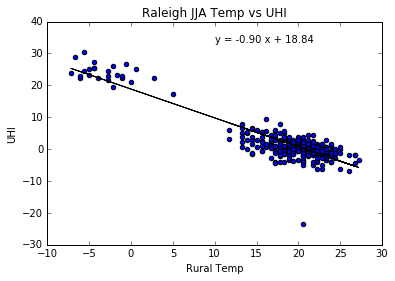

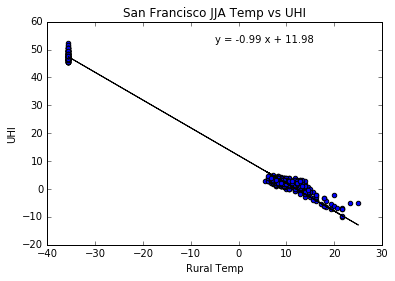

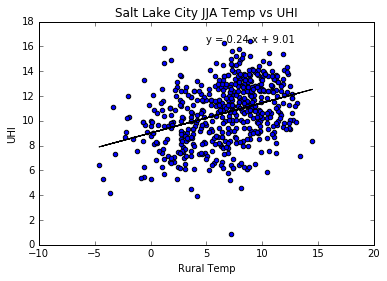

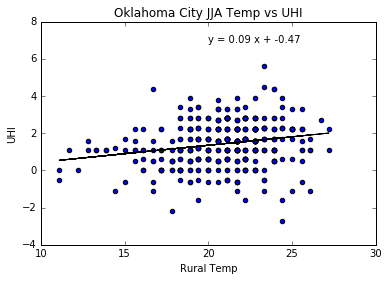

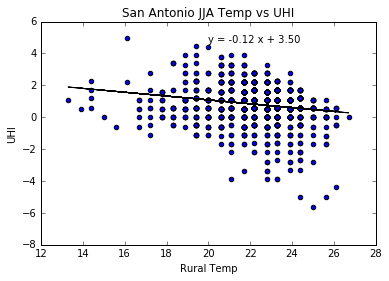

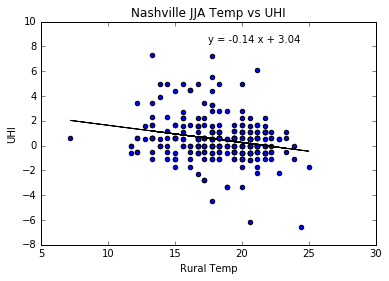

In [64]:
# Look at scatterplots of UHI vs. temp for the following cities: 
# high negative: Raleigh, San Francisco
# high positive: SLC, OKC
# low correlation: San Antonio, Nashville

selected_city_index = [209, 230,205, 207, 208, 212 ]
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]
paired_df = paired_df.loc[[209, 230,205, 207, 208, 212 ]]

slopes           = np.zeros(paired_df.shape[0])
residuals        = np.zeros(paired_df.shape[0])
correlations     = np.zeros(paired_df.shape[0])
p_values         = np.zeros(paired_df.shape[0])
n_events         = np.zeros(paired_df.shape[0])
urban_start_date = np.zeros(paired_df.shape[0])
urban_end_date   = np.zeros(paired_df.shape[0])
rural_start_date = np.zeros(paired_df.shape[0])
rural_end_date   = np.zeros(paired_df.shape[0])

for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 
        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1985
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        #temp = tmin
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year

        #calculate UHI
        UHI = urban_tmin - rural_tmin#pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        #UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        
        x = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
        x = x[x>5]
        y = UHI[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        plt.figure()
        hw_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp', 'UHI')
        try: 
            V = np.polyfit(x[ind],y[ind],1, full = True)
            r, p = scipy.stats.pearsonr(x[ind],y[ind])
            slopes[i] = V[0][0]
            residuals[i] = V[1][0]
            correlations[i] = r# np.corrcoef(x[ind],y[ind])[0,1]
            p_values[i] = p
            n_events[i] = ind.values.sum()
            
            #hw_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp', 'UHI')
        except TypeError : 
            slopes[i] = np.nan
            residuals[i] = np.nan
            correlations[i] = np.nan
            p_values[i] = np.nan
        except IndexError : 
            residuals[i] = np.nan
    else : 
        slopes[i] = np.nan
        residuals[i] = np.nan
        correlations[i] = np.nan
        p_values[i] = np.nan
        
results_df = pd.DataFrame()
results_df['City']  = paired_df['City']
results_df['Slope'] = slopes
results_df['Residual'] = residuals
results_df['Correlation'] = correlations
results_df['P Values'] = p_values
results_df['Urban start date'] = urban_start_date
results_df['Urban end date'] = urban_end_date
results_df['Rural start date'] = rural_start_date
results_df['Rural end date'] = rural_end_date
results_df['Number Data Points'] = n_events


In [63]:
results_df

,City,Slope,Residual,Correlation,P Values,Urban start date,Urban end date,Rural start date,Rural end date,Number Data Points
209,Raleigh,-0.904372,2926.242250,-0.903646,2.769478e-148,1985.0,2016.0,2007.0,2016.0,399.0
230,San Francisco,-0.994491,1886.572595,-0.995113,0.000000e+00,1985.0,2016.0,1998.0,2016.0,890.0
205,Salt Lake City,0.242915,2872.569423,0.354966,1.439670e-17,1985.0,1997.0,1988.0,2016.0,543.0
207,Oklahoma City,0.090951,538.008746,0.211380,1.136443e-05,1996.0,2016.0,2009.0,2016.0,424.0
208,San Antonio,-0.120806,1780.491069,-0.189688,1.717985e-12,1985.0,2016.0,1985.0,2007.0,1361.0
212,Nashville,-0.139589,773.499198,-0.230393,1.415813e-04,2008.0,2016.0,2000.0,2016.0,268.0


In [ ]:
# Calculate the relationship between heatwave days UHI and t_min, save it out for every city
paired_df = pairs[(pairs['Urban brightness'] - pairs['Rural brightness'] > 30) & (pairs['Urban station'].str.contains('US'))]

slopes           = np.zeros(paired_df.shape[0])
residuals        = np.zeros(paired_df.shape[0])
correlations     = np.zeros(paired_df.shape[0])
p_values         = np.zeros(paired_df.shape[0])
n_events         = np.zeros(paired_df.shape[0])
urban_start_date = np.zeros(paired_df.shape[0])
urban_end_date   = np.zeros(paired_df.shape[0])
rural_start_date = np.zeros(paired_df.shape[0])
rural_end_date   = np.zeros(paired_df.shape[0])
mean_rural_temp  = np.zeros(paired_df.shape[0])
mean_UHI         = np.zeros(paired_df.shape[0])
numhw = 150
finalhw = 50

for i in range(0, paired_df.shape[0]): 
    city = paired_df.iloc[i]['City']
    city = unicode(city, errors = 'ignore')
    urbanID = paired_df.iloc[i]['Urban station']
    ruralID = paired_df.iloc[i]['Rural station']
    print city
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(urbanID,
                                         as_dataframe=True, update = False)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(ruralID,
                                         as_dataframe=True, update = False)
    if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) & (np.intersect1d(urbandata['TMIN']['1985-01-01':].index, ruraldata['TMIN']['1985-01-01':].index).shape[0] > 300): 
    #if ('TMIN' in urbandata.keys()) & ('TMIN' in ruraldata.keys()) : 

        # Find the date at which they both start
        startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

        # Calculate minimum daily thresholds starting from 1985
        rural_tmin = pd.to_numeric(ruraldata['TMIN']['1985-01-01':].value/10.) #rural tmin
        urban_tmin = pd.to_numeric(urbandata['TMIN']['1985-01-01':].value/10.) 
        #Get the hottest days based off tmin 
        hottestmin = rural_tmin.iloc[(-rural_tmin.values).argsort()[:numhw]] 
        minheatwaves = hottestmin
        
        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index()[time_diff > np.timedelta64(2, 'D')]
        # Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
        minheatwaves = minheatwaves.sort_values().iloc[0:finalhw]
        
        rural_start_date[i] = rural_tmin[~np.isnan(rural_tmin)].index[0].year
        rural_end_date[i]   = rural_tmin[~np.isnan(rural_tmin)].index[-1].year
        urban_start_date[i] = urban_tmin[~np.isnan(urban_tmin)].index[0].year
        urban_end_date[i]   = urban_tmin[~np.isnan(urban_tmin)].index[-1].year

        #calculate UHI
        UHI = urban_tmin - rural_tmin#pd.to_numeric(urbandata['TMIN'].value/10.)[tmin.index] - tmin
        #UHImax = pd.to_numeric(urbandata['TMAX'].value/10.)[tmax.index] - tmax
        mean_UHI[i] = UHI.mean()
        
        x = rural_tmin[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        mean_rural_temp[i] = x.mean()

        try: 
            V = np.polyfit(x[ind],y[ind],1, full = True)
            r, p = scipy.stats.pearsonr(x[ind],y[ind])
            slopes[i] = V[0][0]
            residuals[i] = V[1][0]
            correlations[i] = r# np.corrcoef(x[ind],y[ind])[0,1]
            p_values[i] = p
            n_events[i] = ind.values.sum()
        except TypeError : 
            slopes[i] = np.nan
            residuals[i] = np.nan
            correlations[i] = np.nan
            p_values[i] = np.nan
        except IndexError : 
            residuals[i] = np.nan
    else : 
        slopes[i] = np.nan
        residuals[i] = np.nan
        correlations[i] = np.nan
        p_values[i] = np.nan
        
results_df = pd.DataFrame()
results_df['City']  = paired_df['City']
results_df['Slope'] = slopes
results_df['Residual'] = residuals
results_df['Correlation'] = correlations
results_df['P Values'] = p_values
results_df['Urban start date'] = urban_start_date
results_df['Urban end date'] = urban_end_date
results_df['Rural start date'] = rural_start_date
results_df['Rural end date'] = rural_end_date
results_df['Mean UHI'] = mean_UHI
results_df['Mean HW Temp'] = mean_rural_temp

results_df.to_csv('HWresults.csv')

In [22]:
rural_tmin.mean()

8.941507408202693

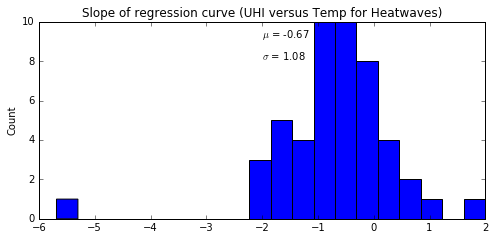

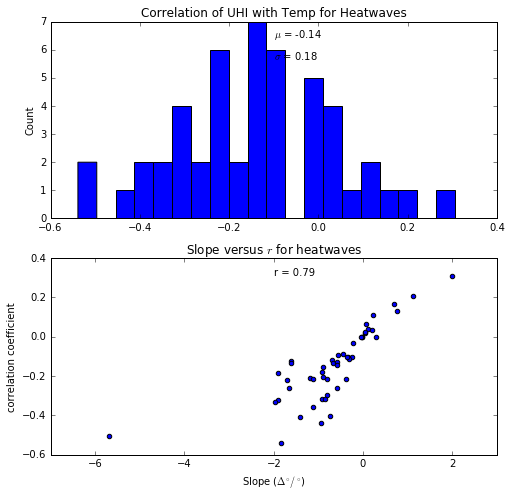

In [19]:
# plot heatwave data 
data = slopes
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,1)
plt.hist(data, 20)
plt.title('Slope of regression curve (UHI versus Temp for Heatwaves)')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

data = correlations
data = data[~np.isnan(data)]
plt.figure(figsize=[8,12])
plt.subplot(3,1,2)
plt.hist(data, 20)
plt.title('Correlation of UHI with Temp for Heatwaves')
#plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
plt.ylabel('Count')
plt.annotate('$ \mu $ = %2.2f'%data.mean(), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$ \sigma $ = %2.2f'%data.std(), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

plt.subplot(3,1,3)
plt.title('Slope versus $r$ for heatwaves')
plt.scatter(slopes, correlations)
plt.xlabel('Slope ($ \Delta ^{\circ} /^{\circ} $)')
#plt.xlim([-1.0,0.2])
plt.ylabel('correlation coefficient')
ind = ~np.isnan(slopes) & ~np.isnan(correlations)
r = np.corrcoef(slopes[ind],correlations[ind])[0,1]
plt.annotate('r = %2.2f'%r, xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

In [783]:
N = 30
autoc = np.zeros([N])
for lag in range(0,N): 
    autoc[lag] = y.autocorr(lag)

    #x.autocorr()

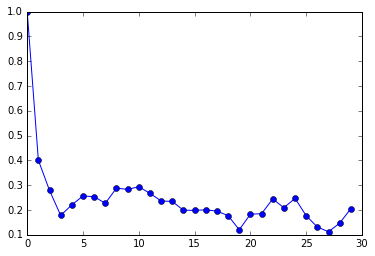

In [785]:
plt.plot(autoc, '-o')

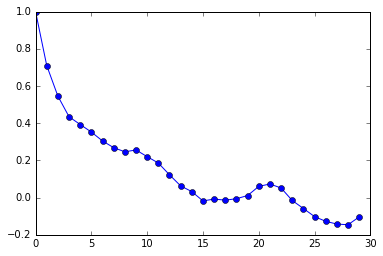

In [790]:
N = 30
autoc = np.zeros([N])
for lag in range(0,N): 
    autoc[lag] = x.autocorr(lag)
plt.plot(autoc, '-o')

# additional questions

We've looked at summertime temp vs UHI for t_min. Look at heatwave temp vs. UHI (maybe also do for t_max?) 
We can also try lagging both of these for one day (temp(n-1) vs UHI(n))
Then we need to start looking at mechanism: consider wind (idea that 2ndary circulation may play a role) versus RH (cities dry out). This hypothesis could also be tested by looking at average NDVI per city and plotting correlation versus vegetation. 

We could also look at surface temperatures to see if they are hotter during heatwaves. 
Lit review: 

Need to also check if results hold for average rural and average urban temperatures (average x number of stations around a city or similar)

In [793]:
import scipy.stats
scipy.stats.pearsonr?

In [809]:
ind = ~np.isnan(y) & ~np.isnan(x)
r, p = scipy.stats.pearsonr(x[ind],y[ind])

In [811]:
p

5.5359119539429672e-30